[View in Colaboratory](https://colab.research.google.com/github/pgurazada/Exploring-Deep-Learning/blob/master/2018_06_08_cats_vs_dogs.ipynb)

##  Data IO

The first part of this workbook authorizes Google Drive to bring the data into the environment by providing access. 

In [0]:
from google.colab import auth
auth.authenticate_user()

In [7]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0


Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting up python-apt (1.4.0~beta3build2) ...
Setting up python3-dbus (1.2.4-1buil

In [0]:
!mkdir -p drive

In [0]:
!google-drive-ocamlfuse drive

In [53]:
!ls drive/data/train

cats  dogs


In [0]:
import os 

In [64]:
print(len(os.listdir('drive/data/train/dogs')), len(os.listdir('drive/data/train/cats')))
print(len(os.listdir('drive/data/validation/dogs')), len(os.listdir('drive/data/validation/cats')))

1000 1000
500 500


## Building the Model

Note that we have a balanced data set here, so accuracy is a good metric

In [0]:
import numpy as np

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

from keras import backend as K

In [0]:
K.clear_session()

In [0]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
__________

In [0]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['acc'])

In [0]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_dir = 'drive/data/train'
validation_dir = 'drive/data/validation'

train_cats_dir = 'drive/data/train/cats'
train_dogs_dir = 'drive/data/train/dogs'

validation_cats_dir = 'drive/data/validation/cats'
validation_dogs_dir = 'drive/data/validation/dogs'

In [68]:
train_generator = train_datagen.flow_from_directory(train_dir, # This is the target directory
                                                    target_size=(150, 150), # All images will be resized to 150x150
                                                    batch_size=20,
                                                    class_mode='binary') # Since we use binary_crossentropy loss, we need binary labels

Found 2000 images belonging to 2 classes.


In [69]:
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [70]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [71]:
model_output = model.fit_generator(train_generator,
                                   steps_per_epoch=100,
                                   epochs=30,
                                   validation_data=validation_generator,
                                   validation_steps=50,
                                   callbacks=[EarlyStopping(patience=2)])

Epoch 1/30
100/100 [==============================] - 1846s 18s/step - loss: 0.6952 - acc: 0.5250 - val_loss: 0.6828 - val_acc: 0.5210
Epoch 2/30
100/100 [==============================] - 23s 227ms/step - loss: 0.6686 - acc: 0.5875 - val_loss: 0.6581 - val_acc: 0.5860
Epoch 3/30
100/100 [==============================] - 23s 233ms/step - loss: 0.6236 - acc: 0.6470 - val_loss: 0.6186 - val_acc: 0.6560
Epoch 4/30
 70/100 [====================>.........] - ETA: 4s - loss: 0.5911 - acc: 0.7021

100/100 [==============================] - 23s 231ms/step - loss: 0.5837 - acc: 0.7080 - val_loss: 0.6082 - val_acc: 0.6550
Epoch 5/30
100/100 [==============================] - 23s 234ms/step - loss: 0.5318 - acc: 0.7525 - val_loss: 0.5871 - val_acc: 0.6850
Epoch 6/30
100/100 [==============================] - 23s 227ms/step - loss: 0.4997 - acc: 0.7650 - val_loss: 0.5862 - val_acc: 0.6880
Epoch 7/30
 88/100 [=========================>....] - ETA: 1s - loss: 0.4687 - acc: 0.7795

100/100 [==============================] - 23s 226ms/step - loss: 0.4767 - acc: 0.7705 - val_loss: 0.5681 - val_acc: 0.7040
Epoch 8/30
100/100 [==============================] - 24s 237ms/step - loss: 0.4481 - acc: 0.7975 - val_loss: 0.5694 - val_acc: 0.7060
Epoch 9/30
100/100 [==============================] - 23s 228ms/step - loss: 0.4166 - acc: 0.8115 - val_loss: 0.5576 - val_acc: 0.7190
Epoch 10/30
 94/100 [===========================>..] - ETA: 0s - loss: 0.3971 - acc: 0.8298

100/100 [==============================] - 24s 239ms/step - loss: 0.3988 - acc: 0.8270 - val_loss: 0.5689 - val_acc: 0.6950
Epoch 11/30
100/100 [==============================] - 23s 226ms/step - loss: 0.3758 - acc: 0.8380 - val_loss: 0.6033 - val_acc: 0.6870


In [72]:
model_output.history

{'acc': [0.525,
  0.587500002682209,
  0.6469999977946281,
  0.708000001013279,
  0.7524999988079071,
  0.765,
  0.7705000013113021,
  0.7975000029802323,
  0.8115000021457672,
  0.8269999980926513,
  0.8379999965429306],
 'loss': [0.6952438390254975,
  0.668605745434761,
  0.6235778433084488,
  0.5836593180894851,
  0.5317618447542191,
  0.4996700033545494,
  0.4767307749390602,
  0.4481227374076843,
  0.4166129994392395,
  0.3987840074300766,
  0.37584931939840316],
 'val_acc': [0.5210000014305115,
  0.5860000014305115,
  0.6560000014305115,
  0.6549999982118606,
  0.6849999988079071,
  0.6879999995231628,
  0.7040000009536743,
  0.7059999996423721,
  0.7189999991655349,
  0.6950000035762787,
  0.6869999969005585],
 'val_loss': [0.6828444266319275,
  0.6581067955493927,
  0.6186458122730255,
  0.6082178544998169,
  0.5870812809467316,
  0.5862436300516128,
  0.5681061518192291,
  0.5694220405817032,
  0.5576211702823639,
  0.5688789123296738,
  0.6033456617593765]}

In [0]:
K.clear_session()

In [0]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))

model.add(Dense(1, activation='sigmoid'))


In [108]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 128)       147584    
__________

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [112]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [113]:
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [114]:
%%time

model_output = model.fit_generator(train_generator,
                                   steps_per_epoch=100,
                                   epochs=100,
                                   validation_data=validation_generator,
                                   validation_steps=50,
                                   callbacks=[EarlyStopping(patience=5)])

Epoch 1/100
100/100 [==============================] - 93s 930ms/step - loss: 0.7005 - acc: 0.5234 - val_loss: 0.6753 - val_acc: 0.5850
Epoch 2/100
100/100 [==============================] - 85s 852ms/step - loss: 0.6828 - acc: 0.5475 - val_loss: 0.6572 - val_acc: 0.6148
Epoch 3/100
100/100 [==============================] - 85s 852ms/step - loss: 0.6658 - acc: 0.5953 - val_loss: 0.6287 - val_acc: 0.6320
Epoch 4/100
 61/100 [=================>............] - ETA: 24s - loss: 0.6416 - acc: 0.6347

100/100 [==============================] - 85s 855ms/step - loss: 0.6404 - acc: 0.6303 - val_loss: 0.6022 - val_acc: 0.6783
Epoch 5/100
100/100 [==============================] - 83s 829ms/step - loss: 0.6163 - acc: 0.6584 - val_loss: 0.5929 - val_acc: 0.6656
Epoch 6/100
100/100 [==============================] - 91s 909ms/step - loss: 0.6029 - acc: 0.6681 - val_loss: 0.5626 - val_acc: 0.6942
Epoch 7/100
 80/100 [=======================>......] - ETA: 13s - loss: 0.6010 - acc: 0.6687

100/100 [==============================] - 87s 871ms/step - loss: 0.6041 - acc: 0.6666 - val_loss: 0.5684 - val_acc: 0.7075
Epoch 8/100
100/100 [==============================] - 86s 858ms/step - loss: 0.5874 - acc: 0.6872 - val_loss: 0.5693 - val_acc: 0.7062
Epoch 9/100
100/100 [==============================] - 86s 863ms/step - loss: 0.5815 - acc: 0.6925 - val_loss: 0.6190 - val_acc: 0.6770
Epoch 10/100
 82/100 [=======================>......] - ETA: 11s - loss: 0.5609 - acc: 0.7085

100/100 [==============================] - 85s 845ms/step - loss: 0.5654 - acc: 0.7003 - val_loss: 0.5401 - val_acc: 0.7202
Epoch 11/100
100/100 [==============================] - 88s 884ms/step - loss: 0.5604 - acc: 0.7038 - val_loss: 0.5397 - val_acc: 0.7145
Epoch 12/100
100/100 [==============================] - 86s 863ms/step - loss: 0.5548 - acc: 0.7213 - val_loss: 0.5658 - val_acc: 0.6999
Epoch 13/100
 82/100 [=======================>......] - ETA: 11s - loss: 0.5452 - acc: 0.7130

100/100 [==============================] - 85s 852ms/step - loss: 0.5474 - acc: 0.7156 - val_loss: 0.5751 - val_acc: 0.6923
Epoch 14/100
100/100 [==============================] - 86s 861ms/step - loss: 0.5405 - acc: 0.7275 - val_loss: 0.5413 - val_acc: 0.7113
Epoch 15/100
100/100 [==============================] - 86s 861ms/step - loss: 0.5403 - acc: 0.7241 - val_loss: 0.5475 - val_acc: 0.7253
Epoch 16/100
 82/100 [=======================>......] - ETA: 11s - loss: 0.5381 - acc: 0.7355

100/100 [==============================] - 86s 865ms/step - loss: 0.5351 - acc: 0.7366 - val_loss: 0.5048 - val_acc: 0.7576
Epoch 17/100
100/100 [==============================] - 81s 813ms/step - loss: 0.5167 - acc: 0.7394 - val_loss: 0.5110 - val_acc: 0.7379
Epoch 18/100
100/100 [==============================] - 93s 930ms/step - loss: 0.5154 - acc: 0.7428 - val_loss: 0.4902 - val_acc: 0.7506
Epoch 19/100
 84/100 [========================>.....] - ETA: 10s - loss: 0.5098 - acc: 0.7440

100/100 [==============================] - 87s 867ms/step - loss: 0.5077 - acc: 0.7453 - val_loss: 0.5111 - val_acc: 0.7462
Epoch 20/100
100/100 [==============================] - 87s 867ms/step - loss: 0.5198 - acc: 0.7422 - val_loss: 0.4948 - val_acc: 0.7582
Epoch 21/100
100/100 [==============================] - 87s 868ms/step - loss: 0.5021 - acc: 0.7525 - val_loss: 0.5941 - val_acc: 0.7132
Epoch 22/100
 82/100 [=======================>......] - ETA: 12s - loss: 0.5020 - acc: 0.7622

100/100 [==============================] - 84s 839ms/step - loss: 0.5080 - acc: 0.7594 - val_loss: 0.5208 - val_acc: 0.7246
Epoch 23/100
100/100 [==============================] - 92s 917ms/step - loss: 0.5043 - acc: 0.7562 - val_loss: 0.5200 - val_acc: 0.7411
CPU times: user 29min 25s, sys: 2min 41s, total: 32min 7s
Wall time: 33min 16s


In [0]:
model.save('drive/data/cats_and_dogs_small_2.h5')

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
sns.set_context('talk', font_scale=1.5)

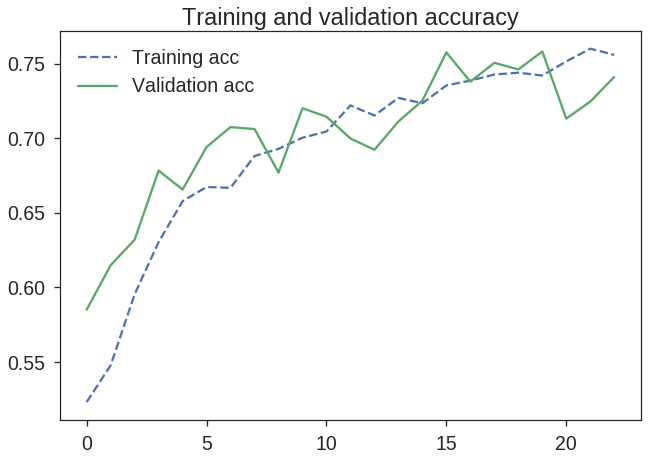

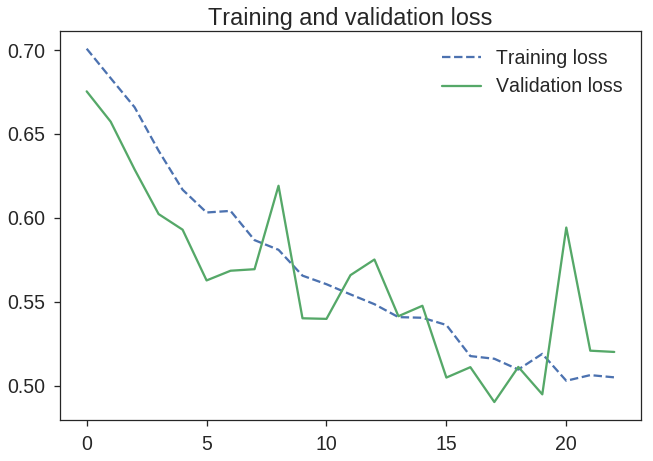

In [115]:
acc = model_output.history['acc']
val_acc = model_output.history['val_acc']
loss = model_output.history['loss']
val_loss = model_output.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--', label='Training acc')
plt.plot(epochs, val_acc, '-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '--', label='Training loss')
plt.plot(epochs, val_loss, '-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [116]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 5s 0us/step


In [117]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [0]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
            
    return features, labels

In [126]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


In [127]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))

In [0]:
K.clear_session()

In [0]:
model = Sequential()

model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [131]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [133]:
model_output = model.fit(train_features, train_labels,
                         epochs=30,
                         batch_size=20,
                         validation_data=(validation_features, validation_labels),
                         callbacks=[EarlyStopping(patience=5)])

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 602us/step - loss: 0.6035 - acc: 0.6655 - val_loss: 0.4501 - val_acc: 0.8230
Epoch 2/30
2000/2000 [==============================] - 1s 508us/step - loss: 0.4386 - acc: 0.8025 - val_loss: 0.3706 - val_acc: 0.8460
Epoch 3/30
2000/2000 [==============================] - 1s 522us/step - loss: 0.3571 - acc: 0.8425 - val_loss: 0.3400 - val_acc: 0.8510
Epoch 4/30
2000/2000 [==============================] - 1s 519us/step - loss: 0.3140 - acc: 0.8775 - val_loss: 0.3001 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 1s 529us/step - loss: 0.2856 - acc: 0.8830 - val_loss: 0.2855 - val_acc: 0.8820
Epoch 6/30
2000/2000 [==============================] - 1s 520us/step - loss: 0.2691 - acc: 0.8920 - val_loss: 0.2790 - val_acc: 0.8880
Epoch 7/30
2000/2000 [==============================] - 1s 526us/step - loss: 0.2467 - acc: 0.9045 - val_loss: 0.2665 - val_acc: 0.8900


2000/2000 [==============================] - 1s 524us/step - loss: 0.2184 - acc: 0.9160 - val_loss: 0.2542 - val_acc: 0.8960
Epoch 10/30
2000/2000 [==============================] - 1s 528us/step - loss: 0.2051 - acc: 0.9235 - val_loss: 0.2530 - val_acc: 0.8980
Epoch 11/30
2000/2000 [==============================] - 1s 532us/step - loss: 0.1975 - acc: 0.9250 - val_loss: 0.2483 - val_acc: 0.9010
Epoch 12/30
2000/2000 [==============================] - 1s 532us/step - loss: 0.1817 - acc: 0.9330 - val_loss: 0.2544 - val_acc: 0.8920
Epoch 13/30
2000/2000 [==============================] - 1s 517us/step - loss: 0.1773 - acc: 0.9310 - val_loss: 0.2427 - val_acc: 0.9030
Epoch 14/30
2000/2000 [==============================] - 1s 524us/step - loss: 0.1733 - acc: 0.9375 - val_loss: 0.2415 - val_acc: 0.8990
Epoch 15/30
2000/2000 [==============================] - 1s 519us/step - loss: 0.1614 - acc: 0.9410 - val_loss: 0.2413 - val_acc: 0.9010
Epoch 16/30
2000/2000 [==============================

2000/2000 [==============================] - 1s 523us/step - loss: 0.1483 - acc: 0.9475 - val_loss: 0.2403 - val_acc: 0.8970
Epoch 18/30
2000/2000 [==============================] - 1s 528us/step - loss: 0.1393 - acc: 0.9520 - val_loss: 0.2356 - val_acc: 0.9070
Epoch 19/30
2000/2000 [==============================] - 1s 510us/step - loss: 0.1358 - acc: 0.9540 - val_loss: 0.2359 - val_acc: 0.9050
Epoch 20/30
2000/2000 [==============================] - 1s 519us/step - loss: 0.1350 - acc: 0.9550 - val_loss: 0.2363 - val_acc: 0.9050
Epoch 21/30
2000/2000 [==============================] - 1s 525us/step - loss: 0.1265 - acc: 0.9630 - val_loss: 0.2357 - val_acc: 0.9040
Epoch 22/30
2000/2000 [==============================] - 1s 527us/step - loss: 0.1241 - acc: 0.9550 - val_loss: 0.2421 - val_acc: 0.9020
Epoch 23/30
2000/2000 [==============================] - 1s 514us/step - loss: 0.1173 - acc: 0.9615 - val_loss: 0.2440 - val_acc: 0.9000


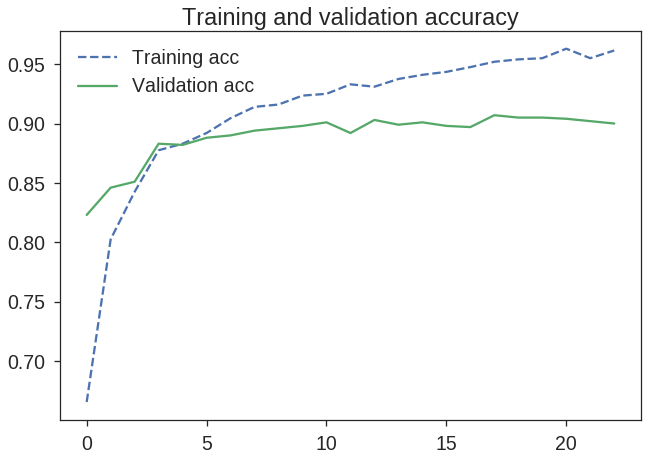

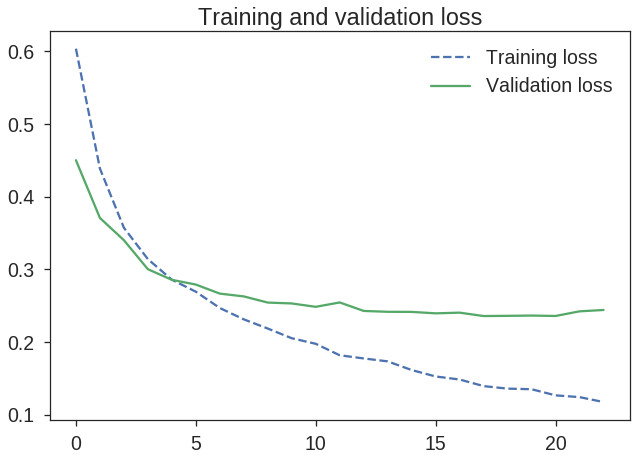

In [134]:
acc = model_output.history['acc']
val_acc = model_output.history['val_acc']
loss = model_output.history['loss']
val_loss = model_output.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--', label='Training acc')
plt.plot(epochs, val_acc, '-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '--', label='Training loss')
plt.plot(epochs, val_loss, '-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
K.clear_session()

In [0]:
model = Sequential()

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

model.add(conv_base)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [138]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv_base.trainable = False

In [140]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

In [142]:
model_output = model.fit_generator(train_generator,
                                   steps_per_epoch=100,
                                   epochs=30,
                                   validation_data=validation_generator,
                                   validation_steps=50,
                                   verbose=2)

Epoch 1/30
 - 42s - loss: 0.5907 - acc: 0.7005 - val_loss: 0.4408 - val_acc: 0.8430
Epoch 2/30
 - 39s - loss: 0.4869 - acc: 0.7705 - val_loss: 0.3663 - val_acc: 0.8600
Epoch 3/30
 - 38s - loss: 0.4333 - acc: 0.8120 - val_loss: 0.3297 - val_acc: 0.8720
Epoch 4/30
 - 39s - loss: 0.4122 - acc: 0.8085 - val_loss: 0.3094 - val_acc: 0.8770
Epoch 5/30
 - 39s - loss: 0.3946 - acc: 0.8275 - val_loss: 0.2928 - val_acc: 0.8910
Epoch 6/30
 - 38s - loss: 0.3615 - acc: 0.8505 - val_loss: 0.2917 - val_acc: 0.8720
Epoch 7/30
 - 39s - loss: 0.3632 - acc: 0.8440 - val_loss: 0.2737 - val_acc: 0.9000
Epoch 8/30
 - 39s - loss: 0.3560 - acc: 0.8510 - val_loss: 0.2663 - val_acc: 0.8990
Epoch 9/30
 - 38s - loss: 0.3348 - acc: 0.8505 - val_loss: 0.2680 - val_acc: 0.8920
Epoch 10/30
 - 39s - loss: 0.3386 - acc: 0.8550 - val_loss: 0.2642 - val_acc: 0.8910
Epoch 11/30
 - 39s - loss: 0.3362 - acc: 0.8585 - val_loss: 0.2745 - val_acc: 0.8840
Epoch 12/30
 - 38s - loss: 0.3191 - acc: 0.8640 - val_loss: 0.2581 - val_a

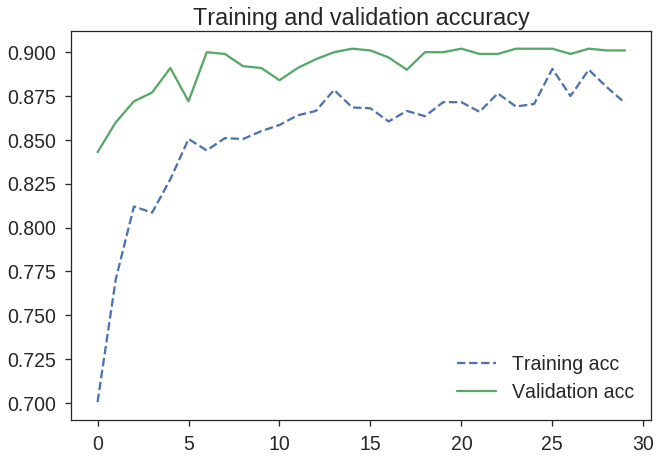

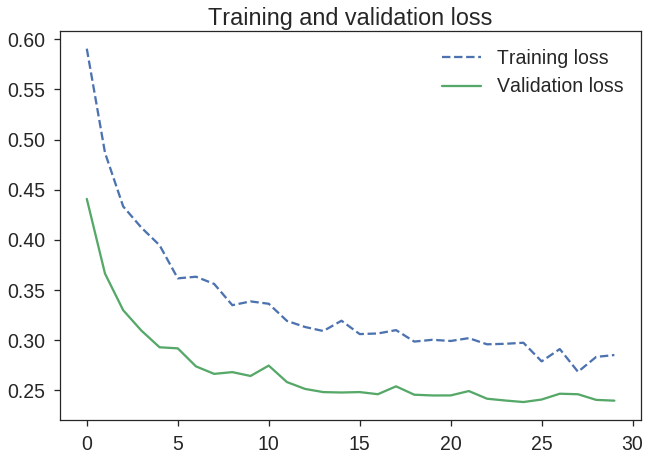

In [143]:
acc = model_output.history['acc']
val_acc = model_output.history['val_acc']
loss = model_output.history['loss']
val_loss = model_output.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--', label='Training acc')
plt.plot(epochs, val_acc, '-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '--', label='Training loss')
plt.plot(epochs, val_loss, '-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()